In [4]:
import pandas as pd

bitcoin_news = pd.read_csv(r"../crypto_news/bitcoin.csv")
coinbase_news = pd.read_csv(r"../crypto_news/coinbase.csv")

bitcoin_news.head()

,Date,ID,News
0,2021-04-14 01:15:37,33799410.0,bitcoin pushes to fresh record high after bre...
1,2021-04-14 07:27:48,33805259.0,bitcoin is not at its bull market top if meas...
2,2021-04-14 08:21:39,33807018.0,gold futures edge lower on wednesday as marke...
3,2021-04-14 08:31:39,33807426.0,open interest on bitcoin futures across the l...
4,2021-04-14 09:26:18,33809664.0,btbt stock is gaining on wednesday ahead of t...


In [5]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="mr8488/distilroberta-finetuned-financial-news-sentiment-analysis-v2",
)

In [6]:
from transformers import AutoTokenizer

# trunctatind news to max allowed tokens
tokenizer = AutoTokenizer.from_pretrained(
    "mr8488/distilroberta-finetuned-financial-news-sentiment-analysis-v2"
)

bitcoin_news["News"] = bitcoin_news["News"].apply(
    lambda x: tokenizer(x, truncation=True, max_length=512)["input_ids"]
)
bitcoin_news["News"] = bitcoin_news["News"].apply(lambda x: tokenizer.decode(x))

coinbase_news["News"] = coinbase_news["News"].apply(
    lambda x: tokenizer(x, truncation=True, max_length=512)["input_ids"]
)
coinbase_news["News"] = coinbase_news["News"].apply(lambda x: tokenizer.decode(x))

In [7]:
# making a function to return setiement
def get_bert_sentiment(news_description):
    try:
        sent = pipe(news_description)
        label = sent[0]["label"]
        score = sent[0]["score"]

        # attempt at making a consolidated label
        if label == "positive":
            combined_label = 1
        elif label == "negative":
            combined_label = -1
        else:
            combined_label = 0

        return pd.Series([label, score, combined_label])

    except IndexError:
        return pd.Series(["BAD Data", 0, 0])


bitcoin_news[["label", "score", "combined_label"]] = bitcoin_news["News"].apply(
    lambda x: get_bert_sentiment(x)
)
coinbase_news[["label", "score", "combined_label"]] = coinbase_news["News"].apply(
    lambda x: get_bert_sentiment(x)
)

bitcoin_news.head()
coinbase_news.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


,Date,ID,News,label,score,combined_label
0,2021-04-13 22:38:36,33797816.0,"<s> cryptocurrency exchange coinbase global, i...",neutral,0.976009,0
1,2021-04-13 23:17:50,33798186.0,<s> it's fetching $600 on ftx's pre-trade mark...,neutral,0.620524,0
2,2021-04-13 23:32:11,33798375.0,<s> coin could give another boost to the tech ...,positive,0.757015,1
3,2021-04-14 01:15:37,33799410.0,<s> bitcoin pushes to fresh record high after ...,positive,0.909999,1
4,2021-04-14 01:21:44,33799527.0,<s> the market capitalization of cryptocurrenc...,positive,0.550074,1


In [8]:
# drop where label is BAD Data
bitcoin_news = bitcoin_news[bitcoin_news["label"] != "BAD Data"]
coinbase_news = coinbase_news[coinbase_news["label"] != "BAD Data"]

# saving back to object store
bitcoin_news.to_csv(r"../crypto_news/bitcoin_news_sentiment.csv")
coinbase_news.to_csv(r"../crypto_news/coinbase_news_sentiment.csv")

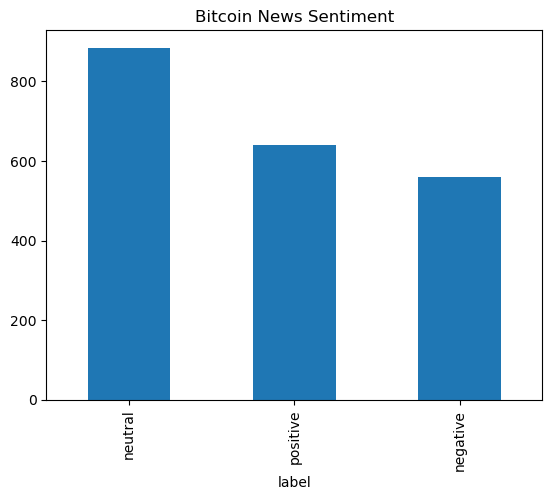

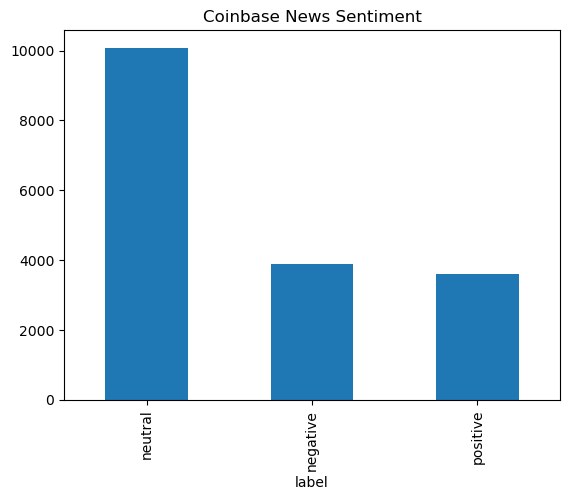

In [9]:
# make some plots to see the sentiment
import matplotlib.pyplot as plt

bitcoin_news["label"].value_counts().plot(kind="bar")
plt.title("Bitcoin News Sentiment")
plt.show()

coinbase_news["label"].value_counts().plot(kind="bar")
plt.title("Coinbase News Sentiment")
plt.show()

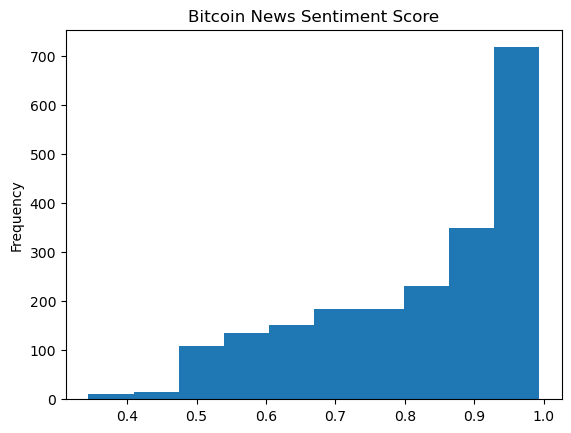

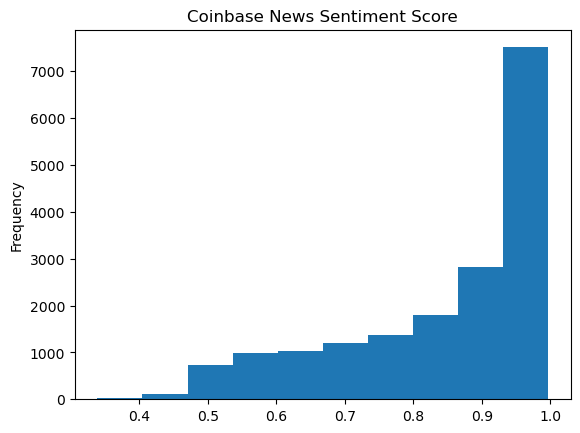

In [10]:
# plot sentiment score
bitcoin_news["score"].plot(kind="hist")
plt.title("Bitcoin News Sentiment Score")
plt.show()

coinbase_news["score"].plot(kind="hist")
plt.title("Coinbase News Sentiment Score")
plt.show()

In [11]:
# convert the Date column to datetime
bitcoin_news["Date"] = pd.to_datetime(bitcoin_news["Date"])
coinbase_news["Date"] = pd.to_datetime(coinbase_news["Date"])

# make a new column 'date' and only keep the day from the 'Date' column
bitcoin_news["date_dt"] = bitcoin_news["Date"].dt.date
bitcoin_news["date_hr"] = bitcoin_news["Date"].dt.hour

coinbase_news["date_dt"] = coinbase_news["Date"].dt.date
coinbase_news["date_hr"] = coinbase_news["Date"].dt.hour

bitcoin_news.head()

,Date,ID,News,label,score,combined_label,date_dt,date_hr
0,2021-04-14 01:15:37,33799410.0,<s> bitcoin pushes to fresh record high after ...,positive,0.909999,1,2021-04-14,1
1,2021-04-14 07:27:48,33805259.0,<s> bitcoin is not at its bull market top if m...,neutral,0.959562,0,2021-04-14,7
2,2021-04-14 08:21:39,33807018.0,<s> gold futures edge lower on wednesday as ma...,neutral,0.586960,0,2021-04-14,8
3,2021-04-14 08:31:39,33807426.0,<s> open interest on bitcoin futures across th...,positive,0.958578,1,2021-04-14,8
4,2021-04-14 09:26:18,33809664.0,<s> btbt stock is gaining on wednesday ahead o...,positive,0.917841,1,2021-04-14,9


In [12]:
coinbase_news.head()

,Date,ID,News,label,score,combined_label,date_dt,date_hr
0,2021-04-13 22:38:36,33797816.0,"<s> cryptocurrency exchange coinbase global, i...",neutral,0.976009,0,2021-04-13,22
1,2021-04-13 23:17:50,33798186.0,<s> it's fetching $600 on ftx's pre-trade mark...,neutral,0.620524,0,2021-04-13,23
2,2021-04-13 23:32:11,33798375.0,<s> coin could give another boost to the tech ...,positive,0.757015,1,2021-04-13,23
3,2021-04-14 01:15:37,33799410.0,<s> bitcoin pushes to fresh record high after ...,positive,0.909999,1,2021-04-14,1
4,2021-04-14 01:21:44,33799527.0,<s> the market capitalization of cryptocurrenc...,positive,0.550074,1,2021-04-14,1


In [13]:
def get_news_count(df, label):
    news_count = (
        df[df["label"] == label]
        .groupby(["date_dt", "date_hr"])
        .count()["News"]
        .reset_index()
    )
    news_count.columns = ["date_dt", "date_hr", f"{label}_count"]
    return news_count


# function to get average sentiment score
def get_avg_sentiment(df, label):
    avg_sentiment = (
        df[df["label"] == label]
        .groupby(["date_dt", "date_hr"])["score"]
        .mean()
        .reset_index()
    )
    avg_sentiment.columns = ["date_dt", "date_hr", f"{label}_avg_score"]
    return avg_sentiment


# Get the news count for each label
pn = get_news_count(bitcoin_news, "positive")
nn = get_news_count(bitcoin_news, "negative")
neun = get_news_count(bitcoin_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment(bitcoin_news, "positive")
nn_avg = get_avg_sentiment(bitcoin_news, "negative")
neun_avg = get_avg_sentiment(bitcoin_news, "neutral")

# Merge the dataframes
merged = pd.merge(pn, nn, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, neun, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, pn_avg, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, nn_avg, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, neun_avg, on=["date_dt", "date_hr"], how="outer")

# Fill NaN values with 0
merged = merged.fillna(0)

# total news count
merged["total_news_count"] = (
    merged["positive_count"] + merged["negative_count"] + merged["neutral_count"]
)

merged["total_news_score"] = (
    merged["positive_avg_score"] * merged["positive_count"]
) - (merged["negative_avg_score"] * merged["negative_count"])

merged["signal"] = (merged["positive_count"] - merged["negative_count"]) / (
    merged["positive_count"] + merged["negative_count"]
)

merged.head(15)

,date_dt,date_hr,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-14,1,1.0,0.0,0.0,0.909999,0.000000,0.000000,1.0,0.909999,1.0
1,2021-04-14,8,1.0,0.0,1.0,0.958578,0.000000,0.586960,2.0,0.958578,1.0
2,2021-04-14,9,2.0,0.0,0.0,0.916790,0.000000,0.000000,2.0,1.833580,1.0
3,2021-04-14,12,3.0,0.0,0.0,0.881500,0.000000,0.000000,3.0,2.644499,1.0
4,2021-04-14,13,1.0,0.0,3.0,0.990537,0.000000,0.839594,4.0,0.990537,1.0
5,2021-04-14,15,1.0,0.0,0.0,0.853825,0.000000,0.000000,1.0,0.853825,1.0
6,2021-04-14,17,1.0,0.0,0.0,0.881410,0.000000,0.000000,1.0,0.881410,1.0
7,2021-04-15,1,1.0,0.0,0.0,0.344422,0.000000,0.000000,1.0,0.344422,1.0
8,2021-04-15,2,1.0,0.0,0.0,0.376431,0.000000,0.000000,1.0,0.376431,1.0
9,2021-04-15,6,1.0,0.0,0.0,0.910463,0.000000,0.000000,1.0,0.910463,1.0


In [14]:
# Get the news count for each label
pn = get_news_count(coinbase_news, "positive")
nn = get_news_count(coinbase_news, "negative")
neun = get_news_count(coinbase_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment(coinbase_news, "positive")
nn_avg = get_avg_sentiment(coinbase_news, "negative")
neun_avg = get_avg_sentiment(coinbase_news, "neutral")

# Merge the dataframes
merged_c = pd.merge(pn, nn, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, neun, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, pn_avg, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, nn_avg, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, neun_avg, on=["date_dt", "date_hr"], how="outer")

# Fill NaN values with 0
merged_c = merged_c.fillna(0)

# total news count
merged_c["total_news_count"] = (
    merged_c["positive_count"] + merged_c["negative_count"] + merged_c["neutral_count"]
)

merged_c["total_news_score"] = (
    merged_c["positive_avg_score"] * merged_c["positive_count"]
) - (merged_c["negative_avg_score"] * merged_c["negative_count"])


merged_c["signal"] = (merged_c["positive_count"] - merged_c["negative_count"]) / (
    merged_c["positive_count"] + merged_c["negative_count"]
)

merged_c.head(15)

,date_dt,date_hr,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-13,23,1.0,0.0,1.0,0.757015,0.000000,0.620524,2.0,0.757015,1.000000
1,2021-04-14,1,2.0,0.0,1.0,0.730036,0.000000,0.955020,3.0,1.460072,1.000000
2,2021-04-14,2,1.0,0.0,0.0,0.731784,0.000000,0.000000,1.0,0.731784,1.000000
3,2021-04-14,6,1.0,0.0,5.0,0.512272,0.000000,0.822194,6.0,0.512272,1.000000
4,2021-04-14,8,5.0,0.0,3.0,0.813772,0.000000,0.806942,8.0,4.068858,1.000000
5,2021-04-14,9,2.0,0.0,6.0,0.916790,0.000000,0.910176,8.0,1.833580,1.000000
6,2021-04-14,10,3.0,2.0,13.0,0.688351,0.915028,0.853299,18.0,0.234999,0.200000
7,2021-04-14,11,1.0,1.0,3.0,0.785931,0.937878,0.879732,5.0,-0.151946,0.000000
8,2021-04-14,12,6.0,1.0,6.0,0.888387,0.687268,0.926318,13.0,4.643054,0.714286
9,2021-04-14,13,10.0,1.0,11.0,0.805662,0.582134,0.898751,22.0,7.474488,0.818182


In [15]:
# save the data
merged.to_csv(r"../crypto_news/bitcoin_news_sentiment_hourly.csv")
merged_c.to_csv(r"../crypto_news/coinbase_news_sentiment_hourly.csv")

<Figure size 1000x800 with 0 Axes>

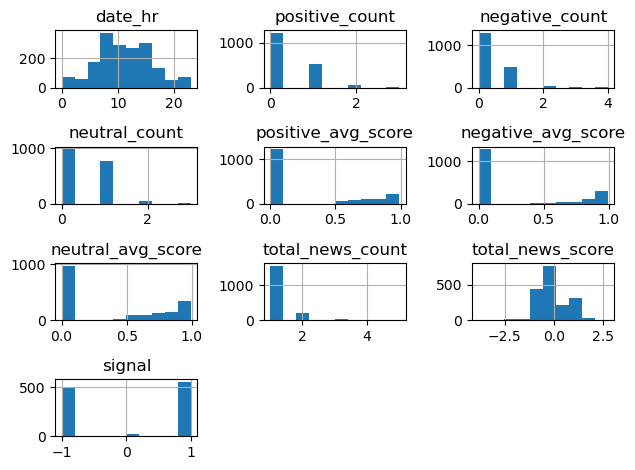

In [16]:
# see distributions of each column other than date_dt and date_hr
plt.figure(figsize=(10, 8))  # Set the figure size
merged.hist()
plt.tight_layout()
plt.show()

In [17]:
def get_news_count_d(df, label):
    news_count = (
        df[df["label"] == label].groupby(["date_dt"]).count()["News"].reset_index()
    )
    news_count.columns = ["date_dt", f"{label}_count"]
    return news_count


# function to get average sentiment score
def get_avg_sentiment_d(df, label):
    avg_sentiment = (
        df[df["label"] == label].groupby(["date_dt"])["score"].mean().reset_index()
    )
    avg_sentiment.columns = ["date_dt", f"{label}_avg_score"]
    return avg_sentiment


# Get the news count for each label
pn = get_news_count_d(bitcoin_news, "positive")
nn = get_news_count_d(bitcoin_news, "negative")
neun = get_news_count_d(bitcoin_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment_d(bitcoin_news, "positive")
nn_avg = get_avg_sentiment_d(bitcoin_news, "negative")
neun_avg = get_avg_sentiment_d(bitcoin_news, "neutral")

# Merge the dataframes
merged_d = pd.merge(pn, nn, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, neun, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, pn_avg, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, nn_avg, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, neun_avg, on="date_dt", how="outer")

# Fill NaN values with 0
merged_d = merged_d.fillna(0)

# total news count
merged_d["total_news_count"] = (
    merged_d["positive_count"] + merged_d["negative_count"] + merged_d["neutral_count"]
)

merged_d["total_news_score"] = (
    merged_d["positive_avg_score"] * merged_d["positive_count"]
) - (merged_d["negative_avg_score"] * merged_d["negative_count"])

merged_d["signal"] = (merged_d["positive_count"] - merged_d["negative_count"]) / (
    merged_d["positive_count"] + merged_d["negative_count"]
)

merged_d.head(15)

,date_dt,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-14,10.0,2.0,10.0,0.907243,0.959677,0.849137,22.0,7.153074,0.666667
1,2021-04-15,6.0,10.0,7.0,0.623000,0.895473,0.726584,23.0,-5.216728,-0.250000
2,2021-04-16,1.0,2.0,3.0,0.725935,0.804262,0.818327,6.0,-0.882589,-0.333333
3,2021-04-18,2.0,6.0,1.0,0.886130,0.962285,0.899825,9.0,-4.001452,-0.500000
4,2021-04-19,3.0,5.0,2.0,0.867508,0.785640,0.786233,10.0,-1.325677,-0.250000
5,2021-04-20,3.0,3.0,1.0,0.722198,0.895534,0.726419,7.0,-0.520008,0.000000
6,2021-04-21,1.0,1.0,5.0,0.642196,0.476256,0.731610,7.0,0.165940,0.000000
7,2021-04-23,1.0,11.0,3.0,0.586266,0.906848,0.899653,15.0,-9.389061,-0.833333
8,2021-04-26,4.0,0.0,4.0,0.667551,0.000000,0.856313,8.0,2.670203,1.000000
9,2021-04-27,3.0,1.0,4.0,0.758420,0.778474,0.956341,8.0,1.496786,0.500000


In [18]:
# Get the news count for each label
pn = get_news_count_d(coinbase_news, "positive")
nn = get_news_count_d(coinbase_news, "negative")
neun = get_news_count_d(coinbase_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment_d(coinbase_news, "positive")
nn_avg = get_avg_sentiment_d(coinbase_news, "negative")
neun_avg = get_avg_sentiment_d(coinbase_news, "neutral")

# Merge the dataframes
merged_dc = pd.merge(pn, nn, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, neun, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, pn_avg, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, nn_avg, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, neun_avg, on="date_dt", how="outer")

# Fill NaN values with 0
merged_dc = merged_dc.fillna(0)

# total news count
merged_dc["total_news_count"] = (
    merged_dc["positive_count"]
    + merged_dc["negative_count"]
    + merged_dc["neutral_count"]
)

merged_dc["total_news_score"] = (
    merged_dc["positive_avg_score"] * merged_dc["positive_count"]
) - (merged_dc["negative_avg_score"] * merged_dc["negative_count"])


merged_dc["signal"] = (merged_dc["positive_count"] - merged_dc["negative_count"]) / (
    merged_dc["positive_count"] + merged_dc["negative_count"]
)

merged_dc.head(5)

,date_dt,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-13,1.0,0.0,2.0,0.757015,0.000000,0.798267,3.0,0.757015,1.000000
1,2021-04-14,44.0,23.0,94.0,0.786364,0.817363,0.884040,161.0,15.800676,0.313433
2,2021-04-15,51.0,28.0,73.0,0.823400,0.890134,0.858108,152.0,17.069662,0.291139
3,2021-04-16,14.0,12.0,44.0,0.794744,0.798550,0.832263,70.0,1.543819,0.076923
4,2021-04-17,3.0,2.0,9.0,0.662382,0.733936,0.782948,14.0,0.519274,0.200000


In [19]:
# save the data
merged_d.to_csv(r"../crypto_news/bitcoin_news_sentiment_daily.csv")
merged_dc.to_csv(r"../crypto_news/coinbase_news_sentiment_daily.csv")

### Lag the news for 1 day

In [20]:
merged_d_lag1 = merged_d.shift(1).dropna()
merged_dc_lag1 = merged_dc.shift(1).dropna()

In [21]:
merged_d_lag1.to_csv("../Data/bitcoin_news_sentiment_daily_lag1.csv")
merged_dc_lag1.to_csv("../Data/coinbase_news_sentiment_daily_lag1.csv")